In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('full_df.csv')
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [4]:
def has_cataract(text):
    if "cataract" in text:
        return 1

In [5]:
def is_normal(text):
    if "normal fundus" in text:
        return 1

In [6]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = df.loc[(df.C == 1) & (df['left_cataract'] == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df['right_cataract'] == 1)]["Right-Fundus"].values

In [7]:
df["left_normal"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_normal(x))
df["right_normal"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_normal(x))
left_normal = df.loc[(df.N ==1) & (df["left_normal"] == 1)]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.N ==1) & (df['right_normal'] == 1)]["Right-Fundus"].sample(300, random_state=42).values

In [8]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


print(len(cataract))
print(len(normal))

594
600


In [9]:
from tqdm import tqdm
import cv2
import os, random

dataset_dir = "ocular-disease-recognition-odir5k/preprocessed_images"
labels = []
dataset = []
image_size=224

def create_dataset(image_category, label):
    processed_images = []  # Stocke les images traitées
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            # Charger l'image
            original_image = cv2.imread(image_path)

            # Convertir l'image en niveaux de gris
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            # Ajuster la luminosité à zéro
            zero_brightness_image = np.zeros_like(original_image)

            # Appliquer une vignette à 20%
            mask = np.zeros_like(gray_image)
            cv2.circle(mask, (gray_image.shape[1] // 2, gray_image.shape[0] // 2), int(min(gray_image.shape) // 2 * 0.8), 255, -1)
            vignette_image = cv2.merge([gray_image * (mask / 255.0)] * 3)

            # Ajuster la clarté à 100%
            clarity_image = cv2.detailEnhance(vignette_image, sigma_s=10, sigma_r=0.15)

            # Redimensionner l'image
            resized_image = cv2.resize(clarity_image, (image_size, image_size))

            # Normaliser les pixels entre 0 et 1
            normalized_image = resized_image / 255.0

            # Ajout de l'image normalisée et l'étiquette à la liste du dataset
            processed_images.append([np.array(normalized_image), np.array(label)])

        except Exception as e:
            print(f"Erreur lors du traitement de l'image {img}: {str(e)}")
            continue

    return processed_images

In [10]:
# Créer les datasets pour chaque catégorie
dataset_cataract = create_dataset(cataract, 1)
dataset_normal = create_dataset(normal, 0)

# Exclure les éléments avec des images vides
dataset_cataract = [item for item in dataset_cataract if item[0] is not None]
dataset_normal = [item for item in dataset_normal if item[0] is not None]
# Concaténer les deux datasets
dataset = dataset_cataract + dataset_normal

# Mélanger le dataset
random.shuffle(dataset)


100%|██████████| 594/594 [00:00<00:00, 18435.96it/s]


Erreur lors du traitement de l'image 0_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Erreur lors du traitement de l'image 81_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Erreur lors du traitement de l'image 103_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Erreur lors du traitement de l'image 119_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Erreur lors du traitement de l'image 254_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error:

100%|██████████| 600/600 [00:00<00:00, 29630.21it/s]

Erreur lors du traitement de l'image 3436_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Erreur lors du traitement de l'image 2443_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Erreur lors du traitement de l'image 2385_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Erreur lors du traitement de l'image 2616_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Erreur lors du traitement de l'image 3017_left.jpg: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199

In [11]:
print("Dataset length:", len(dataset))


Dataset length: 0


In [12]:
import pandas as pd

# Load CSV
df = pd.read_csv("full_df.csv")
print("CSV rows:", len(df))

# Check how many cataract vs normal
print(df['Left-Diagnostic Keywords'].value_counts().head())
print(df['Right-Diagnostic Keywords'].value_counts().head())


CSV rows: 6392
Left-Diagnostic Keywords
normal fundus                             2796
moderate non proliferative retinopathy     717
mild nonproliferative retinopathy          428
cataract                                   268
pathological myopia                        208
Name: count, dtype: int64
Right-Diagnostic Keywords
normal fundus                             2705
moderate non proliferative retinopathy     745
mild nonproliferative retinopathy          472
cataract                                   250
pathological myopia                        216
Name: count, dtype: int64


In [13]:
import cv2
import os
import pandas as pd

# Load CSV
df = pd.read_csv("data/full_df.csv")
print("CSV rows:", len(df))

def build_dataset(df, base_dir="data/ODIR-5K/ODIR-5K"):
    dataset = []
    missing_files = 0

    for _, row in df.iterrows():
        label = None
        # Cataract condition
        if "cataract" in str(row['Left-Diagnostic Keywords']).lower() or \
           "cataract" in str(row['Right-Diagnostic Keywords']).lower():
            label = 1
        # Normal condition (both eyes normal)
        elif "normal fundus" in str(row['Left-Diagnostic Keywords']).lower() and \
             "normal fundus" in str(row['Right-Diagnostic Keywords']).lower():
            label = 0
        else:
            continue  # skip other diseases

        # Try Training Images first
        filepath = os.path.join(base_dir, "Training Images", row['filename'])
        if not os.path.exists(filepath):
            # If not found, try Testing Images
            filepath = os.path.join(base_dir, "Testing Images", row['filename'])

        if os.path.exists(filepath):
            image = cv2.imread(filepath)
            if image is not None:
                dataset.append((image, label))
        else:
            missing_files += 1
            if missing_files < 10:
                print("Missing file:", filepath)

    print("Total missing files:", missing_files)
    return dataset

dataset = build_dataset(df)
print("Dataset length:", len(dataset))


CSV rows: 6392
Total missing files: 0
Dataset length: 2504


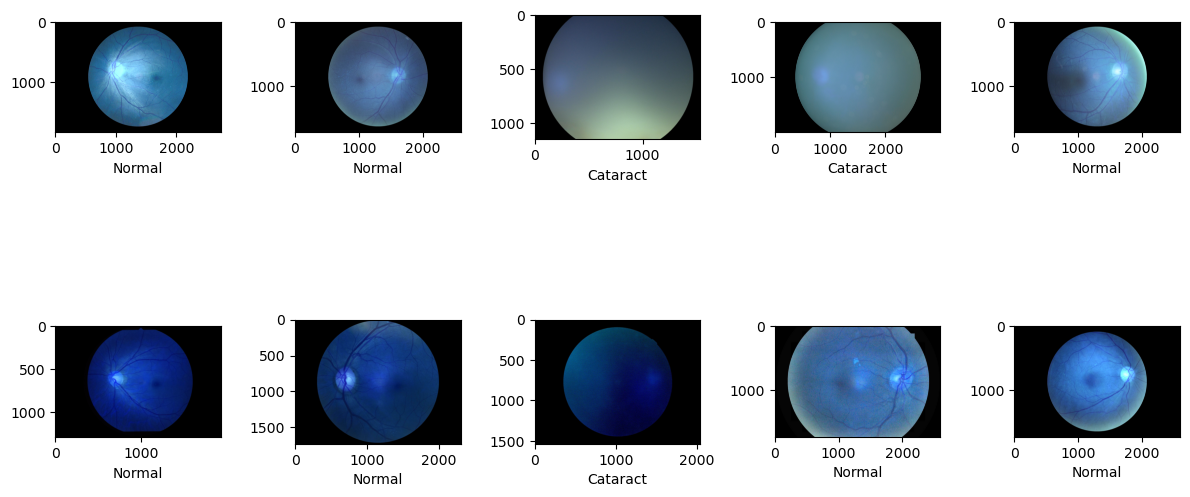

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [15]:
len(dataset)

2504

In [16]:
def preprocess(image, size=(224, 224)):
    image = cv2.resize(image, size)
    image = image / 255.0  # normalize
    return image

x = []
y = []

for image, label in dataset:
    if image is not None:
        image = preprocess(image)
        x.append(image)
        y.append(label)

x = np.array(x)  # now this will work
y = np.array(y).astype(int)


In [17]:
x.shape

(2504, 224, 224, 3)

In [18]:
from sklearn.model_selection import train_test_split

#Diviser les données en ensembles d'entraînement et de test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.5, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
len(y_train)

1252

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
epochs = 25

# Calculer le nombre initial d'images
initial_images = len(x_train)

# Calculer le nombre d'itérations par époque
steps_per_epoch = len(x_train) // batch_size

# Calculer le facteur d'augmentation total
augmentation_factor = steps_per_epoch * epochs

# Calculer le nombre total d'images après l'augmentation
total_generated_images = initial_images * augmentation_factor

In [21]:
import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import tensorflow as tf
import seaborn as sns

In [22]:
#base model 1 InceptionV3
base_model_1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_1.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs=base_model_1.input, outputs=predictions)
for layer in base_model_1.layers:
    layer.trainable = False

model_1.summary()

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
# base model 2 VGG19
base_model_2 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs=base_model_2.input, outputs=x)
for layer in base_model_2.layers:
    layer.trainable = False

model_2.summary()

model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.AUC(name='auc')])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 20,024,897 (76.39 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [24]:
# base model 3 InceptionResNetV2
base_model_3 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

model_3 = Model(inputs=base_model_3.input, outputs=x)
for layer in base_model_3.layers:
    layer.trainable = False

model_3.summary()

model_3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.AUC(name='auc')])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,338,273 (207.28 MB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [32]:
import cv2

size = (224, 224)   # target resolution

image = cv2.resize(image, size)
image = image.astype("float16") / 255.0


In [33]:
def preprocess(image, size=(224,224)):
    image = cv2.resize(image, size)
    image = image.astype("float16") / 255.0
    return image


In [34]:
processed = preprocess(image)


In [ ]:
import numpy as np
import cv2

def preprocess(image, size=(224,224)):
    image = cv2.resize(image, size)      # force same resolution
    image = image.astype("float32") / 255.0  # normalize
    return image

x = []
y = []

for image, label in dataset:
    if image is not None:
        image = preprocess(image)
        x.append(image)
        y.append(label)

x = np.array(x)
y = np.array(y).astype(int)

print("x shape:", x.shape)   # should be (2504, 224, 224, 3)
print("y shape:", y.shape)


MemoryError: Unable to allocate 1.40 GiB for an array with shape (2504, 224, 224, 3) and data type float32

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


In [36]:
model_1.save("base_model_1.h5")

In [38]:
from sklearn.model_selection import train_test_split

# Assuming x and y are full arrays of shape (2504, 224, 224, 3) and (2504,)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)  # should be (1252, 224, 224, 3) and (1252,)


AttributeError: 'list' object has no attribute 'shape'

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set training parameters
batch_size = 32
epochs = 5

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create augmented training generator
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

# Define Model 2 (InceptionV3)
base_model_2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model_2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs=base_model_2.input, outputs=predictions)

# Freeze base model layers
for layer in base_model_2.layers:
    layer.trainable = False

# Compile model
model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Calculate steps per epoch
steps_per_epoch = len(x_train) // batch_size

# Train the model
history_2 = model_2.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_val, y_val),
    verbose=1
)

# Calculate total generated images
total_iterations = steps_per_epoch * epochs
total_generated_images = total_iterations * batch_size

print(f"\nNombre total d'images générées: {total_generated_images}")


ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (224, 224, 3), y.shape = (1252,)

In [ ]:
model_2.save("base_model_2.h5")

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert lists to NumPy arrays
x = np.array(x)   # shape should be (2504, 224, 224, 3)
y = np.array(y)   # shape should be (2504,)

# Now split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("x_train shape:", x_train.shape)  # (1252, 224, 224, 3)
print("y_train shape:", y_train.shape)  # (1252,)


x_train shape: (1252, 224, 224, 3)
y_train shape: (1252,)


In [42]:
#Training The Basic Models

# Augmentation de données pendant l'entraînement
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
 

model_3.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

# Calculer le nombre total d'itérations pendant toutes les époques
total_iterations = steps_per_epoch * epochs

# Afficher le nombre total d'images générées
total_generated_images = total_iterations * batch_size

# Afficher le nombre total d'images générées
print(f"\nNombre total d'images générées: {total_generated_images}")



Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.8299 - auc: 0.6971 - loss: 0.4180 - precision: 0.4054 - recall: 0.1508 - val_accuracy: 0.9010 - val_auc: 0.9142 - val_loss: 0.2459 - val_precision: 0.8571 - val_recall: 0.3913
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.8930 - auc: 0.8886 - loss: 0.2782 - precision: 0.8495 - recall: 0.3970 - val_accuracy: 0.9345 - val_auc: 0.9186 - val_loss: 0.2162 - val_precision: 0.8312 - val_recall: 0.6957
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.9161 - auc: 0.9002 - loss: 0.2563 - precision: 0.8357 - recall: 0.5879 - val_accuracy: 0.9249 - val_auc: 0.9205 - val_loss: 0.2117 - val_precision: 0.8689 - val_recall: 0.5761
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 219s 6s/step - accuracy: 0.9097 - auc: 0.9015 - loss: 0.2534 - precision: 0.7905 - recall: 0.5879 - val_accuracy: 0.9345 - val_auc: 0.9219 - val_loss: 0.2024 - val_precision: 0.8148 - val_recall: 0.7174
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 192

In [43]:
model_3.save("base_model_3.h5")

In [51]:
from tensorflow import keras
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# Load the two working models
pred_model_1 = keras.models.load_model("base_model_1.h5")
pred_model_2 = keras.models.load_model("base_model_2.h5")

# Get predictions
predictions_base_model_1 = pred_model_1.predict(x_test)
predictions_base_model_2 = pred_model_2.predict(x_test)

# Average ensemble
ensemble_preds = (predictions_base_model_1 + predictions_base_model_2) / 2
ensemble_labels = (ensemble_preds > 0.5).astype(int)

# Evaluate
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_labels))
print("Ensemble AUC:", roc_auc_score(y_test, ensemble_preds))


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 705ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 866ms/step
Ensemble Accuracy: 0.9217252396166135
Ensemble AUC: 0.8947432869762966


In [44]:
#Obtention des predictions
from tensorflow import keras

pred_model_1 = keras.models.load_model('base_model_1.h5')
pred_model_2 = keras.models.load_model('base_model_2.h5')
pred_model_3 = keras.models.load_model('base_model_3.h5')

predictions_base_model_1 = pred_model_1.predict(x_test)
predictions_base_model_2 = pred_model_2.predict(x_test)
predictions_base_model_3 = pred_model_3.predict(x_test)

ValueError: Unknown layer: 'CustomScaleLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [53]:
len(y_test)

626

In [55]:
#Creation de l'ensemble de données pour le meta model
stacked_x_test = np.hstack([predictions_base_model_1, predictions_base_model_2])

In [56]:
len(x_test)

626

In [57]:
#meta model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense


adam_optimizer = Adam(learning_rate=0.01)

In [ ]:
meta_model = Sequential()
meta_model.add(Dense(256, input_dim = 3, activation='relu'))
meta_model.add(Dense(128, activation='relu'))
meta_model.add(Dense(64, activation='relu'))
meta_model.add(Dense(32, activation='relu'))
meta_model.add(layers.Dropout(0.5))
meta_model.add(Dense(1, activation='sigmoid'))
meta_model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.AUC(name='auc')])


c:\Users\priks\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
meta_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,289 (173.00 KB)

 Trainable params: 44,289 (173.00 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
meta_model = Sequential()
meta_model.add(Dense(256, input_dim=2, activation='relu'))  # <-- use 2, not 3
meta_model.add(Dense(128, activation='relu'))
meta_model.add(Dense(64, activation='relu'))
meta_model.add(Dense(32, activation='relu'))
meta_model.add(layers.Dropout(0.5))
meta_model.add(Dense(1, activation='sigmoid'))


In [64]:
adam_optimizer = Adam(learning_rate=0.01)
meta_model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

meta_model.summary()

# Train on stacked predictions
meta_model.fit(stacked_x_test, y_test, epochs=100, batch_size=128, verbose=1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,033 (172.00 KB)

 Trainable params: 44,033 (172.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7157 - auc: 0.5453 - loss: 0.6141 - precision: 0.2362 - recall: 0.2703
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8818 - auc: 0.7884 - loss: 0.3731 - precision: 0.8136 - recall: 0.4324 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9169 - auc: 0.8670 - loss: 0.2944 - precision: 0.8242 - recall: 0.6757 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9121 - auc: 0.8939 - loss: 0.2818 - precision: 0.7857 - recall: 0.6937 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9201 - auc: 0.8710 - loss: 0.2906 - precision: 0.8280 - recall: 0.6937 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9233 - auc: 0.8973 - loss: 0.2617 - precision: 0.8316 - recall: 0.7117 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9233 - auc: 0.8798 - loss: 0.2732 - precision: 0.8462 - recall: 0.6937 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accur

In [65]:
meta_model.fit(stacked_x_test, y_test, epochs=100, batch_size=128)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9185 - auc: 0.9056 - loss: 0.2400 - precision: 0.8409 - recall: 0.6667 
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9169 - auc: 0.9079 - loss: 0.2522 - precision: 0.8242 - recall: 0.6757 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9169 - auc: 0.9126 - loss: 0.2372 - precision: 0.8315 - recall: 0.6667 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9249 - auc: 0.9239 - loss: 0.2264 - precision: 0.8478 - recall: 0.7027 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9137 - auc: 0.9141 - loss: 0.2340 - precision: 0.8202 - recall: 0.6577 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9217 - auc: 0.9295 - loss: 0.2202 - precision: 0.8229 - recall: 0.7117 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9153 - auc: 0.9203 - loss: 0.2394 - precision: 0.8295 - recall: 0.6577 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accu

In [ ]:
meta_model.save("meta_model.h5")

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

stacked_predictions_test = meta_model.predict(stacked_x_test)

# Évaluer les performances du modèle méta sur l'ensemble de test
predictions_binary = np.round(stacked_predictions_test)
accuracy_test = accuracy_score(y_test, predictions_binary)
precision_test = precision_score(y_test, predictions_binary)
recall_test = recall_score(y_test, predictions_binary)


print(f"Accuracy of Stacked Model on Test Set: {accuracy_test}")
print(f"Precision of Stacked Model on Test Set: {precision_test}")
print(f"Recall of Stacked Model on Test Set: {recall_test}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy of Stacked Model on Test Set: 0.9217252396166135
Precision of Stacked Model on Test Set: 0.8369565217391305
Recall of Stacked Model on Test Set: 0.6936936936936937


In [72]:
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.optimizers import Adam

meta_model = Sequential([
    Input(shape=(2,)),   # <-- 2 features, not 3
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

adam_optimizer = Adam(learning_rate=0.01)
meta_model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

meta_model.fit(stacked_x_test, y_test, epochs=100, batch_size=128, verbose=1)

# Save in modern format
meta_model.save("meta_model.keras")


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6629 - auc: 0.6511 - loss: 0.5960 - precision: 0.2596 - recall: 0.4865
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9089 - auc: 0.8265 - loss: 0.3107 - precision: 0.8750 - recall: 0.5676 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9217 - auc: 0.8823 - loss: 0.3110 - precision: 0.8370 - recall: 0.6937 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9233 - auc: 0.8714 - loss: 0.2837 - precision: 0.8316 - recall: 0.7117 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9105 - auc: 0.8886 - loss: 0.2727 - precision: 0.8161 - recall: 0.6396 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9201 - auc: 0.8745 - loss: 0.2727 - precision: 0.8280 - recall: 0.6937 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9217 - auc: 0.9025 - loss: 0.2604 - precision: 0.8100 - recall: 0.7297 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accu

In [73]:
pred_meta_model = keras.models.load_model("meta_model.keras")
stacked_predictions_test = pred_meta_model.predict(stacked_x_test)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [74]:
predictions_binary = (stacked_predictions_test > 0.5).astype(int)


In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
auc = roc_auc_score(y_test, stacked_predictions_test)

print(f"Stacked Model Accuracy: {accuracy:.4f}")
print(f"Stacked Model Precision: {precision:.4f}")
print(f"Stacked Model Recall: {recall:.4f}")
print(f"Stacked Model AUC: {auc:.4f}")


Stacked Model Accuracy: 0.9169
Stacked Model Precision: 0.8315
Stacked Model Recall: 0.6667
Stacked Model AUC: 0.9285


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load image

image_path = "drive/MyDrive/mild.png"

#preprocessing
original_image = cv2.imread(image_path)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
zero_brightness_image = np.zeros_like(original_image)
mask = np.zeros_like(gray_image)
cv2.circle(mask, (gray_image.shape[1] // 2, gray_image.shape[0] // 2), int(min(gray_image.shape) // 2 * 0.8), 255, -1)
vignette_image = cv2.merge([gray_image * (mask / 255.0)] * 3)
clarity_image = cv2.detailEnhance(vignette_image, sigma_s=10, sigma_r=0.15)
resized_image = cv2.resize(clarity_image, (image_size, image_size))
normalized_image = resized_image / 255.0

data = normalized_image



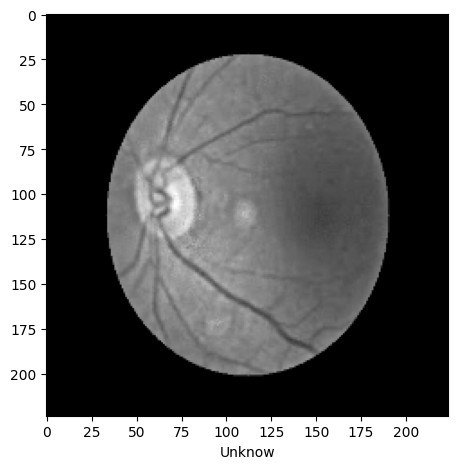

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(data)
plt.xlabel("Unknow")
plt.tight_layout()

In [ ]:
data.shape

(224, 224, 3)

In [ ]:
data_normalized = np.expand_dims(data, axis=0)
data_normalized.shape

(1, 224, 224, 3)

In [76]:
#predictions base models

prediction_1 = pred_model_1.predict(data_normalized)
prediction_2 = pred_model_2.predict(data_normalized)

NameError: name 'data_normalized' is not defined

In [ ]:
input_meta_model = np.hstack([prediction_1, prediction_2, prediction_3])


In [ ]:
final_prediction = meta_model.predict(input_meta_model)

1/1 [==============================] - 0s 21ms/step


In [ ]:
final_prediction

array([[0.00012968]], dtype=float32)

In [79]:
predictions_base_model_1 = pred_model_1.predict(x_test)
predictions_base_model_2 = pred_model_2.predict(x_test)
stacked_x_test = np.hstack([predictions_base_model_1, predictions_base_model_2])
final_predictions = pred_meta_model.predict(stacked_x_test)
final_classes = ['cataract' if p > 0.4 else 'normal' for p in final_predictions.flatten()]


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 642ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 940ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [80]:
threshold = 0.4

# Convertir la prédiction continue en classe binaire
final_class = 'cataract' if final_prediction[0, 0] > threshold else 'normal'

print("The final prediction is:", final_class)


NameError: name 'final_prediction' is not defined